# Import graph

In [1]:
import igraph as ig
import coarse
import random

from data.graph_generator import *

nData = 300
nTasks = 100
edgeProb = 0.12

outgoingEdges = 2

avgDataDep = 4
stddDataDep = 3

# g = generate_realistic(nData, nTasks, avgDataDep, stddDataDep)

# g = generate_graph(nData, nTasks, edgeProb)

# g = generate_barabasi(nData + nTasks, outgoingEdges)
from data.testgraph3 import *

### Eliminate isolated vertices

In [2]:
toDelete = []
for v in g.vs:
    if not v.neighbors():
        toDelete.append(v)
g.delete_vertices(toDelete)

## Plot the graph, define layout and visual style

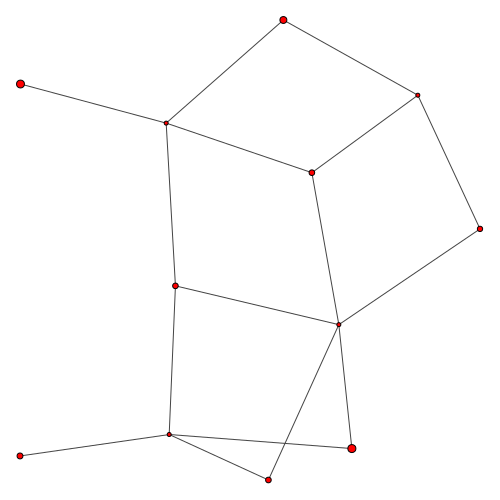

In [3]:
volumes = g.vs["volume"]
maxVolume = max(volumes)

nVertices = len(g.vs)
nEdges = len(g.es)

visual_style = {}

layout = g.layout("fr")
visual_style["layout"] = layout

# g.vs["label"] = g.vs["name"]
# visual_style["vertex_label"] = g.vs["name"]
visual_style["vertex_size"] = [4 * (1 + volumes[i]/maxVolume) for i in range(nVertices)]
visual_style["bbox"] = (500, 500)
visual_style["margin"] = 20


# print("Vertex names:")
# print(["{0}: {1}".format(i, g.vs[i]["name"]) for i in range(len(g.vs))])
# print("\nWeighted edges")
# for e in g.es:
#     print("{0} -- {1}: {2}".format(g.vs[e.source]["name"], g.vs[e.target]["name"], e["weight"]))

ig.plot(g, **visual_style)

## Cluster cost parameters

Generate a random set of clusters

In [4]:
import numpy as np

nClusters = 2
clusters = range(nClusters)


costexp = 30
coststdd = 30

cost = [[0 for c1 in range(nClusters)] for c2 in range(nClusters)]
for c1 in range(nClusters):
    for c2 in range(c1+1, nClusters):
        cost[c1][c2] = max(round(random.gauss(costexp, coststdd),2),0)
        cost[c2][c1] = cost[c1][c2]
cost = np.array(cost)

# cost = np.array([[0., 1.], [1.,0.]])

print(cost)

[[ 0.   80.31]
 [80.31  0.  ]]


## Coarsening the graph
The graph is coarsened until its number of vertices is less than a specified number.

In [5]:
import coarse

vertexLimit = 40
graphs = [g]

while len(graphs[-1].vs) > vertexLimit:
    coarserGraph = coarse.coarsen(graphs[-1])
    graphs.append(coarserGraph)

print(graphs[-1].vs["volume"])

[0.3169612638577681, 0.3935629274577216, 0.45904469645886536, 0.9534063309187585, 0.38698885769535507, 0.6901342711134617, 0.37673604078454703, 0.9215471899395906, 0.0, 0.0, 0.0, 0.0]


1


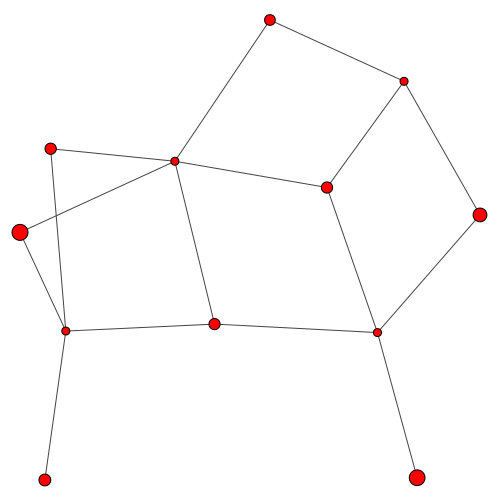

In [6]:
cg = graphs[-1]

volumes = cg.vs["volume"]
maxVolume = max(volumes)

nVertices = len(cg.vs)
vertices = range(nVertices)
nEdges = len(cg.es)

visual_style = {}
layout = cg.layout("fr")
visual_style["layout"] = layout
# cg.vs["label"] = cg.vs["name"]
# visual_style["vertex_label"] = cg.vs["name"]
visual_style["vertex_size"] = [8 * (1 + volumes[i]/maxVolume) for i in range(nVertices)]
visual_style["bbox"] = (500, 500)
visual_style["margin"] = 20


# print("Vertex names:")
# print(["{0}: {1}".format(i, cg.vs[i]["name"]) for i in range(len(cg.vs))])
# print("\nWeighted edges")
# for e in cg.es:
#     print("{0} -- {1}: {2}".format(cg.vs[e.source]["name"], cg.vs[e.target]["name"], e["weight"]))

print(len(graphs))
ig.plot(cg, **visual_style)

# Calculate the initial partition on the coarsest graph, using a LP

## Transform the graph into data

[(0, 8), (0, 9), (1, 8), (1, 10), (2, 10), (3, 8), (3, 10), (4, 9), (4, 11), (6, 11), (7, 11), (4, 8), (6, 8), (5, 9), (6, 10), (5, 11)]
[0.3169612638577681, 0.3935629274577216, 0.45904469645886536, 0.9534063309187585, 0.38698885769535507, 0.6901342711134617, 0.37673604078454703, 0.9215471899395906, 0.0, 0.0, 0.0, 0.0]


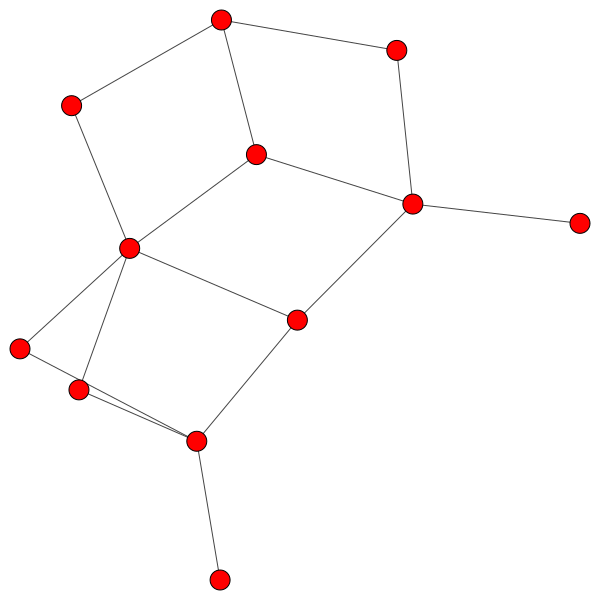

In [7]:
cg = graphs[-1]
nVertices = len(cg.vs)
range(nVertices)
nEdges = len(cg.es)

tolerance = 0.2

volumes = cg.vs["volume"]
totalVolume = max(volumes)
maxVolume = max(volumes)
loadPerCluster = totalVolume * (1 + tolerance) / nClusters
edgeWeight = cg.es["weight"]
edges = [(e.source, e.target) for e in cg.es]

print(edges)
print(volumes)
ig.plot(cg)

## Initialize solver

In [8]:
from ortools.linear_solver import pywraplp

# Instantiate a mixed-integer solver, naming it SolveIntegerProblem.
solver = pywraplp.Solver('SolveIntegerProblem',
                           pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
# print(edges)

## Define variables

In [9]:
edgecut = {(i,j,k,l): solver.BoolVar('e_{0}_{1}_{2}_{3}'.format(i,j,k,l)) for (i,j) in edges for k in clusters for l in clusters}
# print(e)

v = [[solver.BoolVar('v_{0}_{1}'.format(i,k)) for k in clusters] for i in vertices]
# print(v)

## Define objective function

In [23]:
objective = solver.Objective()
for (i,j) in edges:
    for k in clusters:
        for l in clusters:
            #print((volumes[i]+volumes[j]) * cost[k,l])
            objective.SetCoefficient(edgecut[(i,j,k,l)], (volumes[i]+volumes[j]) * cost[k,l])
            print(objective.GetCoefficient(edgecut[(i,j,k,l)]))
            
objective.SetMinimization()

0.0
25.455159100417358
25.455159100417358
0.0
0.0
25.455159100417358
25.455159100417358
0.0
0.0
31.60703870412962
31.60703870412962
0.0
0.0
31.60703870412962
31.60703870412962
0.0
0.0
36.865879572611476
36.865879572611476
0.0
0.0
76.5680624360855
76.5680624360855
0.0
0.0
76.5680624360855
76.5680624360855
0.0
0.0
31.079075161513966
31.079075161513966
0.0
0.0
31.079075161513966
31.079075161513966
0.0
0.0
30.255671435406974
30.255671435406974
0.0
0.0
74.00945482404852
74.00945482404852
0.0
0.0
31.079075161513966
31.079075161513966
0.0
0.0
30.255671435406974
30.255671435406974
0.0
0.0
55.42468331312211
55.42468331312211
0.0
0.0
30.255671435406974
30.255671435406974
0.0
0.0
55.42468331312211
55.42468331312211
0.0


## Define constraints

In [16]:
# All the vertices are in one partition
distributed = [solver.Constraint(1., 1.) for i in vertices]
for i in vertices:
    for k in clusters:
        distributed[i].SetCoefficient(v[i][k], 1.)
        
# Balance out the partition load
balance = [solver.Constraint(-solver.infinity(), loadPerCluster) for k in clusters]
for k in clusters:
    for i in vertices:
        balance[k].SetCoefficient(v[i][k], volumes[i])

# Linearisation of v_i_k * v_j_l = e_i_j_k_l
lin1 = {(i,j): [[solver.Constraint(-solver.infinity(), 0) for l in clusters] for k in clusters] for (i,j) in edges}
lin2 = {(i,j): [[solver.Constraint(-solver.infinity(), 0) for l in clusters] for k in clusters] for (i,j) in edges}
lin3 = {(i,j): [[solver.Constraint(-1, solver.infinity()) for l in clusters] for k in clusters] for (i,j) in edges}
for (i,j) in edges:
    for k in clusters:
        for l in clusters:
            lin1[(i,j)][k][l].SetCoefficient(edgecut[(i,j,k,l)], 1)
            lin1[(i,j)][k][l].SetCoefficient(v[i][k], -1)
            lin2[(i,j)][k][l].SetCoefficient(edgecut[(i,j,k,l)], 1)
            lin2[(i,j)][k][l].SetCoefficient(v[j][l], -1)
            lin3[(i,j)][k][l].SetCoefficient(edgecut[(i,j,k,l)], 1)
            lin3[(i,j)][k][l].SetCoefficient(v[i][k], -1)
            lin3[(i,j)][k][l].SetCoefficient(v[j][l], -1)
print(objective)

<ortools.linear_solver.pywraplp.Objective; proxy of <Swig Object of type 'operations_research::MPObjective *' at 0x0000000005E9EEA0> >


# Solve and get partition

In [12]:
result_status = solver.Solve()
# The problem has an optimal solution.
# assert result_status == pywraplp.Solver.OPTIMAL
# assert(solver.VerifySolution(1e-7, True))

print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())

# The objective value of the solution.
print('Optimal objective value = %d' % solver.Objective().Value())
print()

Number of variables = 88
Number of constraints = 206
Optimal objective value = 0



In [13]:
print("Placement:")
placement = []

for i in vertices:
    for k in clusters:
        print(v[i][k].solution_value())

for i in vertices:
    for k in clusters:
        if v[i][k].solution_value() > 0.5:
            print("{0} --> {1}".format(cg.vs["name"][i],k))
            placement.append(k)
            
cutEdges = []
for e in cg.es:
    if placement[e.source] != placement[e.target]:
        cutEdges.append(True)
    else:
        cutEdges.append(False)
            
color_dict_vertex = {0: "blue", 1: "red", 2: "green", 3: "pink", 4: "orange" }
visual_style = {}
visual_style["layout"] = layout
visual_style["vertex_label"] = cg.vs["name"]
visual_style["vertex_size"] = 20
visual_style["bbox"] = (400, 400)
visual_style["margin"] = 100
visual_style["vertex_size"] = [20 + volumes[i]*50/(2*maxVolume) for i in vertices]
visual_style["vertex_color"] = [color_dict_vertex[placement[i]] for i in vertices]
visual_style["edge_color"] = ["black" if cutEdges[i] else color_dict_vertex[placement[cg.es[i].source]] for i in range(nEdges)]
ig.plot(cg, **visual_style)

Placement:
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


IndexError: list index out of range